# Saving simulation results

You can run ZPIC inside the notebook (or any interactive Python/iPython session) and access all the simulation data directly in memory, without writing any output to disk, as described in the [ZPIC](ZPIC.ipynb) notebook in this folder. For most situations this is the recommended way of using the code. However, if you your simulation takes a long time to compute, you may want to write diagnostic information to disk for post-processing later.

To do this you must define the required diagnostics in a python function that accepts as a single argument a simulation object. This routine will be called once per iteration, and it can access global variables defined in the Python code. 

This routine needs to be specified at the moment of the `Simulation` object creation, as detailed below. All the main simulation objects (fields, current, particle species) have a `report()` method that can used to save diagnostic information to disk.

## Example

To illustrate this procedure we will be repeating the Two-Stream instability example from the [ZPIC](ZPIC.ipynb) notebook. In this example we will be saving, at every 10 time steps:
* The raw particle data of the right going species
* The raw particle data of the left going species
* The $E_x$ field grid

Our diagnostics function would then be:

In [1]:
ndump = 10      # frequency at which to write diagnostic information

def rep( sim ):
    # sim.n has the current simulation iteration
    if (sim.n % ndump == 0):
        right.report("particles")    # Raw particle data
        left.report("particles")     # Raw particle data
        sim.emf.report("E",0)        # E field, 0 component (x)

The simulation is then initialized the same way, adding the function we just created as the keyword `report` when creating the `Simulation` object:

In [2]:
import numpy as np
import sys
sys.path.append("../../lib")

import em1ds as zpic

m_q = -1.0                   # mass over charge ratio, in normalized units (1.0 would be a positron)
ppc = 500                    # number of particles per cell
ufl = [0.4,    0.0,  0.0]    # fluid momenta
uth = [0.001,0.001,0.001]    # thermal momenta

# Right going electron species
right = zpic.Species( "right", m_q, ppc, ufl = ufl, uth = uth )

# Left going electron species
ufl[0] = -ufl[0]
left  = zpic.Species( "left", m_q, ppc, ufl = ufl, uth = uth )

import numpy as np

nx = 120               # Number of grid cells
box = 4 * np.pi        # Simulation box size
dt = 0.1               # Time step

# Simulation object
sim = zpic.Simulation( nx, box, dt, species = [right,left],
      report = rep )   # The report keyword specifies the diagnostic function to be called

Just as before we run the simulation use the `run` method, giving the final time as the sole parameter:

In [3]:
sim.run(50)


Running simulation up to t = 50 ...
n = 501, t = 50.1
Done.


### Additional diagnostics

ZPIC includes 3 different types of particle species diagnostics that can be selected using the parameters of the `Species.report()` method:
* __Raw particle data__, as shown above.
* __Charge density__, specified by the "charge" value, e.g. `left.report("charge")`
* __2D phasespace density__, specified by the "pha" value and additional keywords.

Doing a phasespace density report requires specifying which quantities will be used for the phasespace axis (`quants` keyword), the number of point in each axis (`pha_nx` keyword) and the range for each phasespace axis (`pha_range` keyword), e.g.:
```python
right.report("pha",                       # Phasespace density
    quants = ["x1","u1"],                 # Use 'x1' in the x axis and 'u1' in the y axis
    pha_nx = [120,256],                   # Use a 120 x 256 grid
    pha_range = [[0,4*np.pi],             # Use [0, 4*pi] range for the x1 axis
                 [-1.5,1.5]]              # and [-1.5, 1.5] for the u1 axis
)
```

## Accessing simulation results

Just like in the C version simulations, results will be saved in the current directory, using the following directory structure:
* `EMF` - Field data
* `PARTICLES` - Raw particle data
* "_species name_" - Charge and phasespace density for that species (not used in this example)

Simulation results are saved in the ZDF format, as in the rest of the ZPIC framework. The included module `zdf` is used for reading these files into Python.

### Grid data

The ZDF files are self-describing, including both the simulation data and the corresponing metadata. ZDF files are read using the ZDF `read()` function:

```python
import zdf
(data, info) = zdf.read("file name.zdf")
```

The data will be returned as a 1D or 2D NumPy array, and the metadata will be returned as a `ZDF_Info` object, see the `zdf` module for more details.

To read and plot a grid data file, including detailed simulation time and units information, we would do:

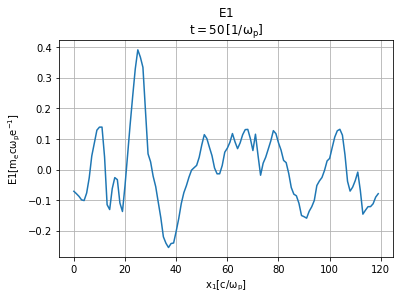

In [4]:
import zdf
import matplotlib.pyplot as plt

(data,info) = zdf.read("EMF/E1-000500.zdf")

xlabel = info.grid.axis[0].label + ' [' + info.grid.axis[0].units + ']'
ylabel = info.grid.label + ' [' + info.grid.units + ']'
title = info.grid.label
timeLabel = "t = {:g}\,[{:s}]".format(info.iteration.t, info.iteration.tunits)

plt.plot(data)
plt.title(r'$\sf{' + title + r'}$' + '\n' + r'$\sf{'+ timeLabel+ r'}$')

plt.xlabel(r'$\sf{' +xlabel+ r'}$')
plt.ylabel(r'$\sf{' +ylabel+ r'}$')

plt.grid(True)
plt.show()

### Particle data

Just like for grid data, the data file includes both the simulation output and metadata. The particle data is organized as a dictionary containing the keys:
* `x1`, `x2` (2D codes only) - Particle positions references to the lower boundary of the simulation box
* `u1`, `u2`, `u3` - Particle generalized velocities

Metadata is returned as a `ZDF_Info` object, see the `zdf` module for more details.

To do a `u1-x1` phasespace from raw particle data, including time / units information we could do:

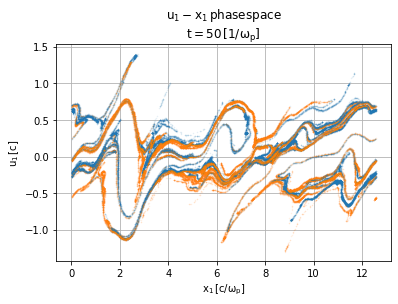

In [5]:
import zdf
import matplotlib.pyplot as plt

(particles,info) = zdf.read("PARTICLES/particles-right-000500.zdf")

x = particles['x1']
y = particles['u1']

plt.plot(x, y, '.', ms=1,alpha=0.1)


title = "u_1-x_1\,phasespace"
timeLabel = "t = {:g}\,[{:s}]".format(info.iteration.t, info.iteration.tunits)

plt.title(r'$\sf{' + title + r'}$' + '\n' + r'$\sf{' + timeLabel + r'}$')

xlabel = "x_1\,[{:s}]".format( info.particles.units['x1'] )
ylabel = "u_1\,[{:s}]".format( info.particles.units['u1'] )

plt.xlabel(r'$\sf{' + xlabel + r'}$')
plt.ylabel(r'$\sf{' + ylabel + r'}$')

(particles,info) = zdf.read("PARTICLES/particles-left-000500.zdf")

x = particles['x1']
y = particles['u1']

plt.plot(x, y, '.', ms=1,alpha=0.1)

plt.grid(True)

plt.show()